
\DeclareMathOperator{\Div}{Div}
\newcommand{\dx}{{\rm dx}}
# Mixed method for the Poisson equation
.. index:: Equations; Poisson (Mixed formulation)

.. index:: Methods; Mixed FEM

.. index:: Spaces; Raviart Thomas and BDM

.. sectionauthor:: contribution by Philip Herbert <P.Herbert@sussex.ac.uk>

We use Dune to solve a simple elliptic problem using a mixed method.
This requires the use of $H(\Div)$ spaces.

We are interested in the problem that
$u \in H^1_0(\Omega)$ satisfies
\begin{align*}
-\Delta u &= f  && \text{in } \Omega,\\
u &= 0     && \text{on } \partial \Omega.
\end{align*}
in variational form for some $f \in H^{-1}(\Omega)$.

It may however be convenient to rewrite the condition $-\Delta u = f$ as $-\Div ( \nabla u ) = f$, and replace $\nabla u$ with $\sigma$.
Since we wish to take divergence of $\sigma$, it makes sense to require that it is in $H(\Div)$.
We thus end up with the following system of equations:
\begin{align*}
\Div \sigma &=-f  && \text{in } \Omega,\\
\sigma - \nabla u &= 0  && \text{in } \Omega,\\
u &= 0     && \text{on } \partial \Omega.
\end{align*}

Performing integration by parts and multiplying by appropriate test functions, we arrive at the problem to find $(\sigma,u) \in H(\Div,\Omega) \times L^2(\Omega)$ such that
\begin{align*}
\int_\Omega \left(\sigma \cdot \tau + u \Div \tau  + v \Div \sigma \right) \dx = \int_{\Omega} -f v\dx
\end{align*}
for all $(\tau, v) \in H(\Div,\Omega) \times L^2(\Omega)$.
Note that in this formulation the condition
$u = 0$ on $\partial \Omega$ is a \emph{natural} boundary condition.
Other boundary conditions can be considered. For example Neumann
boundary conditions need to be enforced through the correct choice of the
space, i.e., are essential boundary conditions.
So switching from $u=0$ on the boundary to $\nabla u\cdot n=0$ leads to the
same variational formulation but over the spaces $L^2$ and
\begin{align*}
H_0(\Div,\Omega):=\{\sigma\in H(\Div,\Omega)\colon \sigma\cdot n=0\;\text{on}\; \partial\Omega \}~.
\end{align*}

One may verify that the system introduced above is well posed.
We are left to choose an appropriate pair of spaces to approximate
$H(\Div,\Omega) \times L^2(\Omega)$.
One such example is the pair of Raviart-Thomas elements and DG functions
of suitable order.

We start by setting up a grid (either a cube or a simplex grid) and the
corresponding pair of spaces:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dune.grid import structuredGrid
from dune.alugrid import aluSimplexGrid
from dune.fem.space import dgonb, dglegendre, raviartThomas, bdm
def getGridSpace(element,space,order):
    if element == "simplex":
        vertices = [ (0,0), (0,1), (1,1), (1,0), (0.5,0.5)]
        triangles = [ [0,1,4], [1,2,4], [2,3,4], [3,0,4] ]
        gridView = aluSimplexGrid({"vertices":vertices, "simplices":triangles})
    else:
        gridView = structuredGrid([0, 0], [1, 1], [2, 2])

    if space == "RT":
        spaceHDiv = raviartThomas(gridView,order = order)
    else:
        spaceHDiv = bdm(gridView,order = order+1)
    if element == "simplex" or not space == "RT":
        spaceDG = dgonb(gridView, order = order)
    else:
        spaceDG = dglegendre(gridView, order = order)
    return gridView, spaceHDiv, spaceDG

Finally, we setup the problem, extracting the matrices used for solving
the Shur complement problem:

In [2]:
from ufl import (TrialFunction, TestFunction, SpatialCoordinate,
                 div, dx, sin, cos, pi, inner, grad)
from dune.ufl import DirichletBC
from dune.fem import assemble, integrate
from dune.fem.function import gridFunction
def getMatrices(spaceHDiv, spaceDG, dirichlet):
    x = SpatialCoordinate(spaceHDiv)
    if dirichlet:
        exSol = sin(pi*x[0])*sin(pi*x[1])
    else:
        exSol = cos(pi*x[0])*cos(pi*x[1])
    f = -div(grad(exSol))

    sigma = TrialFunction(spaceHDiv)
    tau   = TestFunction(spaceHDiv)

    u     = TrialFunction(spaceDG)
    v     = TestFunction(spaceDG)

    A     = inner(sigma,tau)*dx
    BT    = inner(u,div(tau))*dx
    B     = inner(div(sigma),v)*dx

    if not dirichlet:
        dbc = DirichletBC(spaceHDiv,grad(exSol))
    else:
        dbc = None

    rhs_b = f*v*dx

    return (assemble([A,dbc]).as_numpy,
            assemble([BT,dbc]).as_numpy,
            assemble(B).as_numpy,
            assemble(rhs_b).as_numpy,
            exSol)

The system we are interested in solving is a saddle point.
To make this easier to solve, we use a Schur complement solver.
Phrasing our problem in block matrix formation as
\begin{equation} \begin{pmatrix} A & B^t\\ B & 0 \end{pmatrix} \begin{pmatrix} \sigma_h \\ v_h \end{pmatrix} = \begin{pmatrix} 0 \\ -f_h \end{pmatrix}, \end{equation}
it holds that $\sigma_h = - A^{-1} B^t u_h$ and $B \sigma_h = -f_h$, hence $B A^{-1} B^t u_h = f_h$.

In [3]:
from scipy.sparse.linalg import cg, splu, LinearOperator
def schur_op(B,BT,invA,x):
    y = BT @ x
    y2 = invA.solve(y)
    return B @ y2
def solveSys(invA,B,BT, target,rhs):
    schur_comp = LinearOperator( (target.shape[0],target.shape[0]),
                                 matvec = lambda x: schur_op(B,BT,invA,x) )
    target[:], info = cg(schur_comp, rhs, x0 = target)

A simple loop to compute the experimental order of convergence and
plotting the laplacian of the result (we of course actually plot
${\rm div\sigma_h}$

In [4]:
def simulate(gridView, spaceHDiv, spaceDG, dirichlet):
    gradSol = spaceHDiv.function(name = "gradSol")
    sol = spaceDG.function(name = "sol")

    refs = 4
    fig, axs = plt.subplots(1,refs, figsize=(10,10))

    print("L^2    H^1    div",flush=True)
    for i in range(refs):
        gridView.hierarchicalGrid.globalRefine()
        A,BT,B,b,exSol = getMatrices(spaceHDiv, spaceDG, dirichlet)
        invA = splu(A.tocsc())
        solveSys(invA,B,BT, target = sol.as_numpy[:],rhs = b)
        gradSol.as_numpy[:] = invA.solve(-BT @ sol.as_numpy)
        err = np.sqrt( integrate([
                         (sol-exSol)**2,
                         inner(gradSol-grad(exSol),gradSol-grad(exSol)),
                         (div(gradSol-grad(exSol)))**2
                       ]) )
        print(err,flush=True)
        gridFunction(div(gradSol)).plot( level=spaceDG.order+1, figure=(fig, axs[i]) )
    print("---------------------",flush=True)

Test this on cubes with the RT space and on simplices using BDM

RTc 0 
-----------


L^2    H^1    div


[0.15666997 0.50136955 3.13222112]


[0.07969768 0.25151378 1.5782216 ]


[0.0400218  0.12587387 0.79063305]


[0.0200326  0.06295197 0.39550707]


---------------------


RTc 1 
-----------


L^2    H^1    div


[0.01611101 0.05101296 0.31876038]


[0.00405488 0.01276262 0.08008621]


[0.0010154  0.00319146 0.02004615]


[0.00025396 0.00079792 0.00501307]


---------------------


RTc 2 
-----------


L^2    H^1    div


[0.00107114 0.0033767  0.0211691 ]


[0.00013463 0.00042331 0.00265828]


[1.68517541e-05 5.29526930e-05 3.32666023e-04]


[2.10719462e-06 6.62571464e-06 6.80311570e-05]


---------------------


RTc 3 
-----------


L^2    H^1    div


[5.30529577e-05 1.67006514e-04 1.04806045e-03]


[3.33152443e-06 1.06326085e-05 1.19111676e-04]


[2.08454514e-07 6.64910398e-07 1.24866878e-05]


[1.30321802e-08 5.24118888e-08 1.98423508e-05]


---------------------


RTc 4 
-----------


L^2    H^1    div


[2.09566940e-06 6.60058412e-06 4.27807074e-05]


[6.57626886e-08 2.39114583e-07 1.43400152e-05]


[2.05695430e-09 7.46071324e-09 8.52126033e-07]


[6.42944792e-11 2.33298979e-10 5.27695936e-08]


---------------------


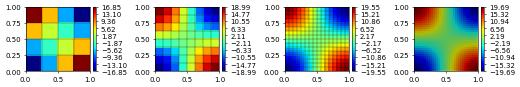

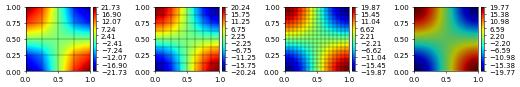

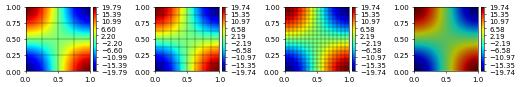

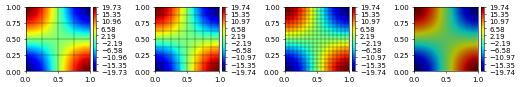

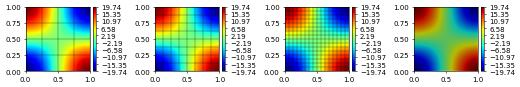

In [5]:
for order in [0,1,2,3,4]:
    gridView, spaceHDiv, spaceDG = getGridSpace("cube", "RT", order)
    print("RTc",spaceHDiv.order,"\n-----------",flush=True)
    simulate(gridView, spaceHDiv, spaceDG, dirichlet=False)

BDMs 1 
-----------


L^2    H^1    div


[0.22396421 0.37234584 4.34414131]


[0.11048716 0.08841037 2.16712621]


[0.05496372 0.02187392 1.0830885 ]


[0.0274441  0.00545601 0.54148935]


---------------------


BDMs 2 
-----------


L^2    H^1    div


[0.03462291 0.03896342 0.69804841]


[0.00883866 0.00469738 0.17662235]


[0.00222179 0.00057914 0.0442949 ]


[5.56211390e-04 7.20156043e-05 1.10829477e-02]


---------------------


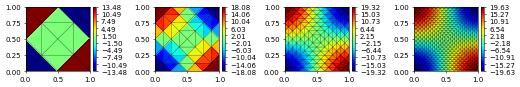

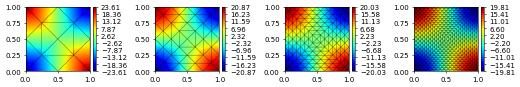

In [6]:
for order in [0,1]:
    # Note that the bdm space is constructed with order+1
    gridView, spaceHDiv, spaceDG = getGridSpace("simplex", "BDM", order)
    print("BDMs",spaceHDiv.order,"\n-----------",flush=True)
    simulate(gridView, spaceHDiv, spaceDG, dirichlet=False)

Let's switch the grids around

RTs 0 
-----------


L^2    H^1    div


[0.16441844 0.98953143 2.66716272]


[0.07404398 0.50172216 1.39079526]


[0.03602131 0.25159084 0.70223988]


[0.01788641 0.12588447 0.35196622]


---------------------


RTs 1 
-----------


L^2    H^1    div


[0.03563509 0.18685304 0.69145713]


[0.00889652 0.04642103 0.17625923]


[0.00222534 0.01160017 0.04427258]


[0.00055643 0.0029003  0.01108197]


---------------------


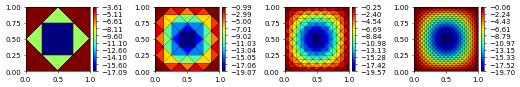

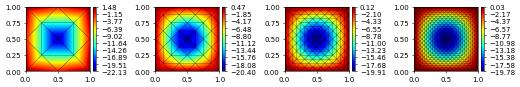

In [7]:
for order in [0,1]:
    gridView, spaceHDiv, spaceDG = getGridSpace("simplex", "RT", order)
    print("RTs",spaceHDiv.order,"\n-----------",flush=True)
    simulate(gridView, spaceHDiv, spaceDG, dirichlet=True)

BDMc 1 
-----------


L^2    H^1    div


[0.15828278 0.16140532 3.13222112]


[0.07994061 0.04037309 1.5782216 ]


[0.04005353 0.0100933  0.79063305]


[0.02003661 0.00252331 0.39550707]


---------------------


BDMc 2 
-----------


L^2    H^1    div


[0.02971146 0.01834503 0.58610934]


[0.0075569  0.00219582 0.14917893]


[0.00189779 0.00027119 0.03746223]


[4.74991820e-04 3.37941903e-05 9.37605517e-03]


---------------------


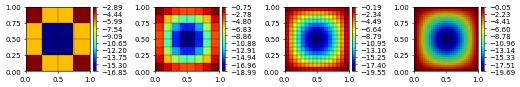

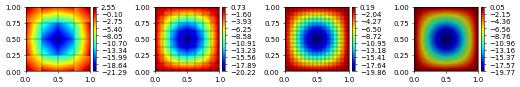

In [8]:
for order in [0,1]:
    gridView, spaceHDiv, spaceDG = getGridSpace("cube", "BDM", order)
    print("BDMc",spaceHDiv.order,"\n-----------",flush=True)
    simulate(gridView, spaceHDiv, spaceDG, dirichlet=True)